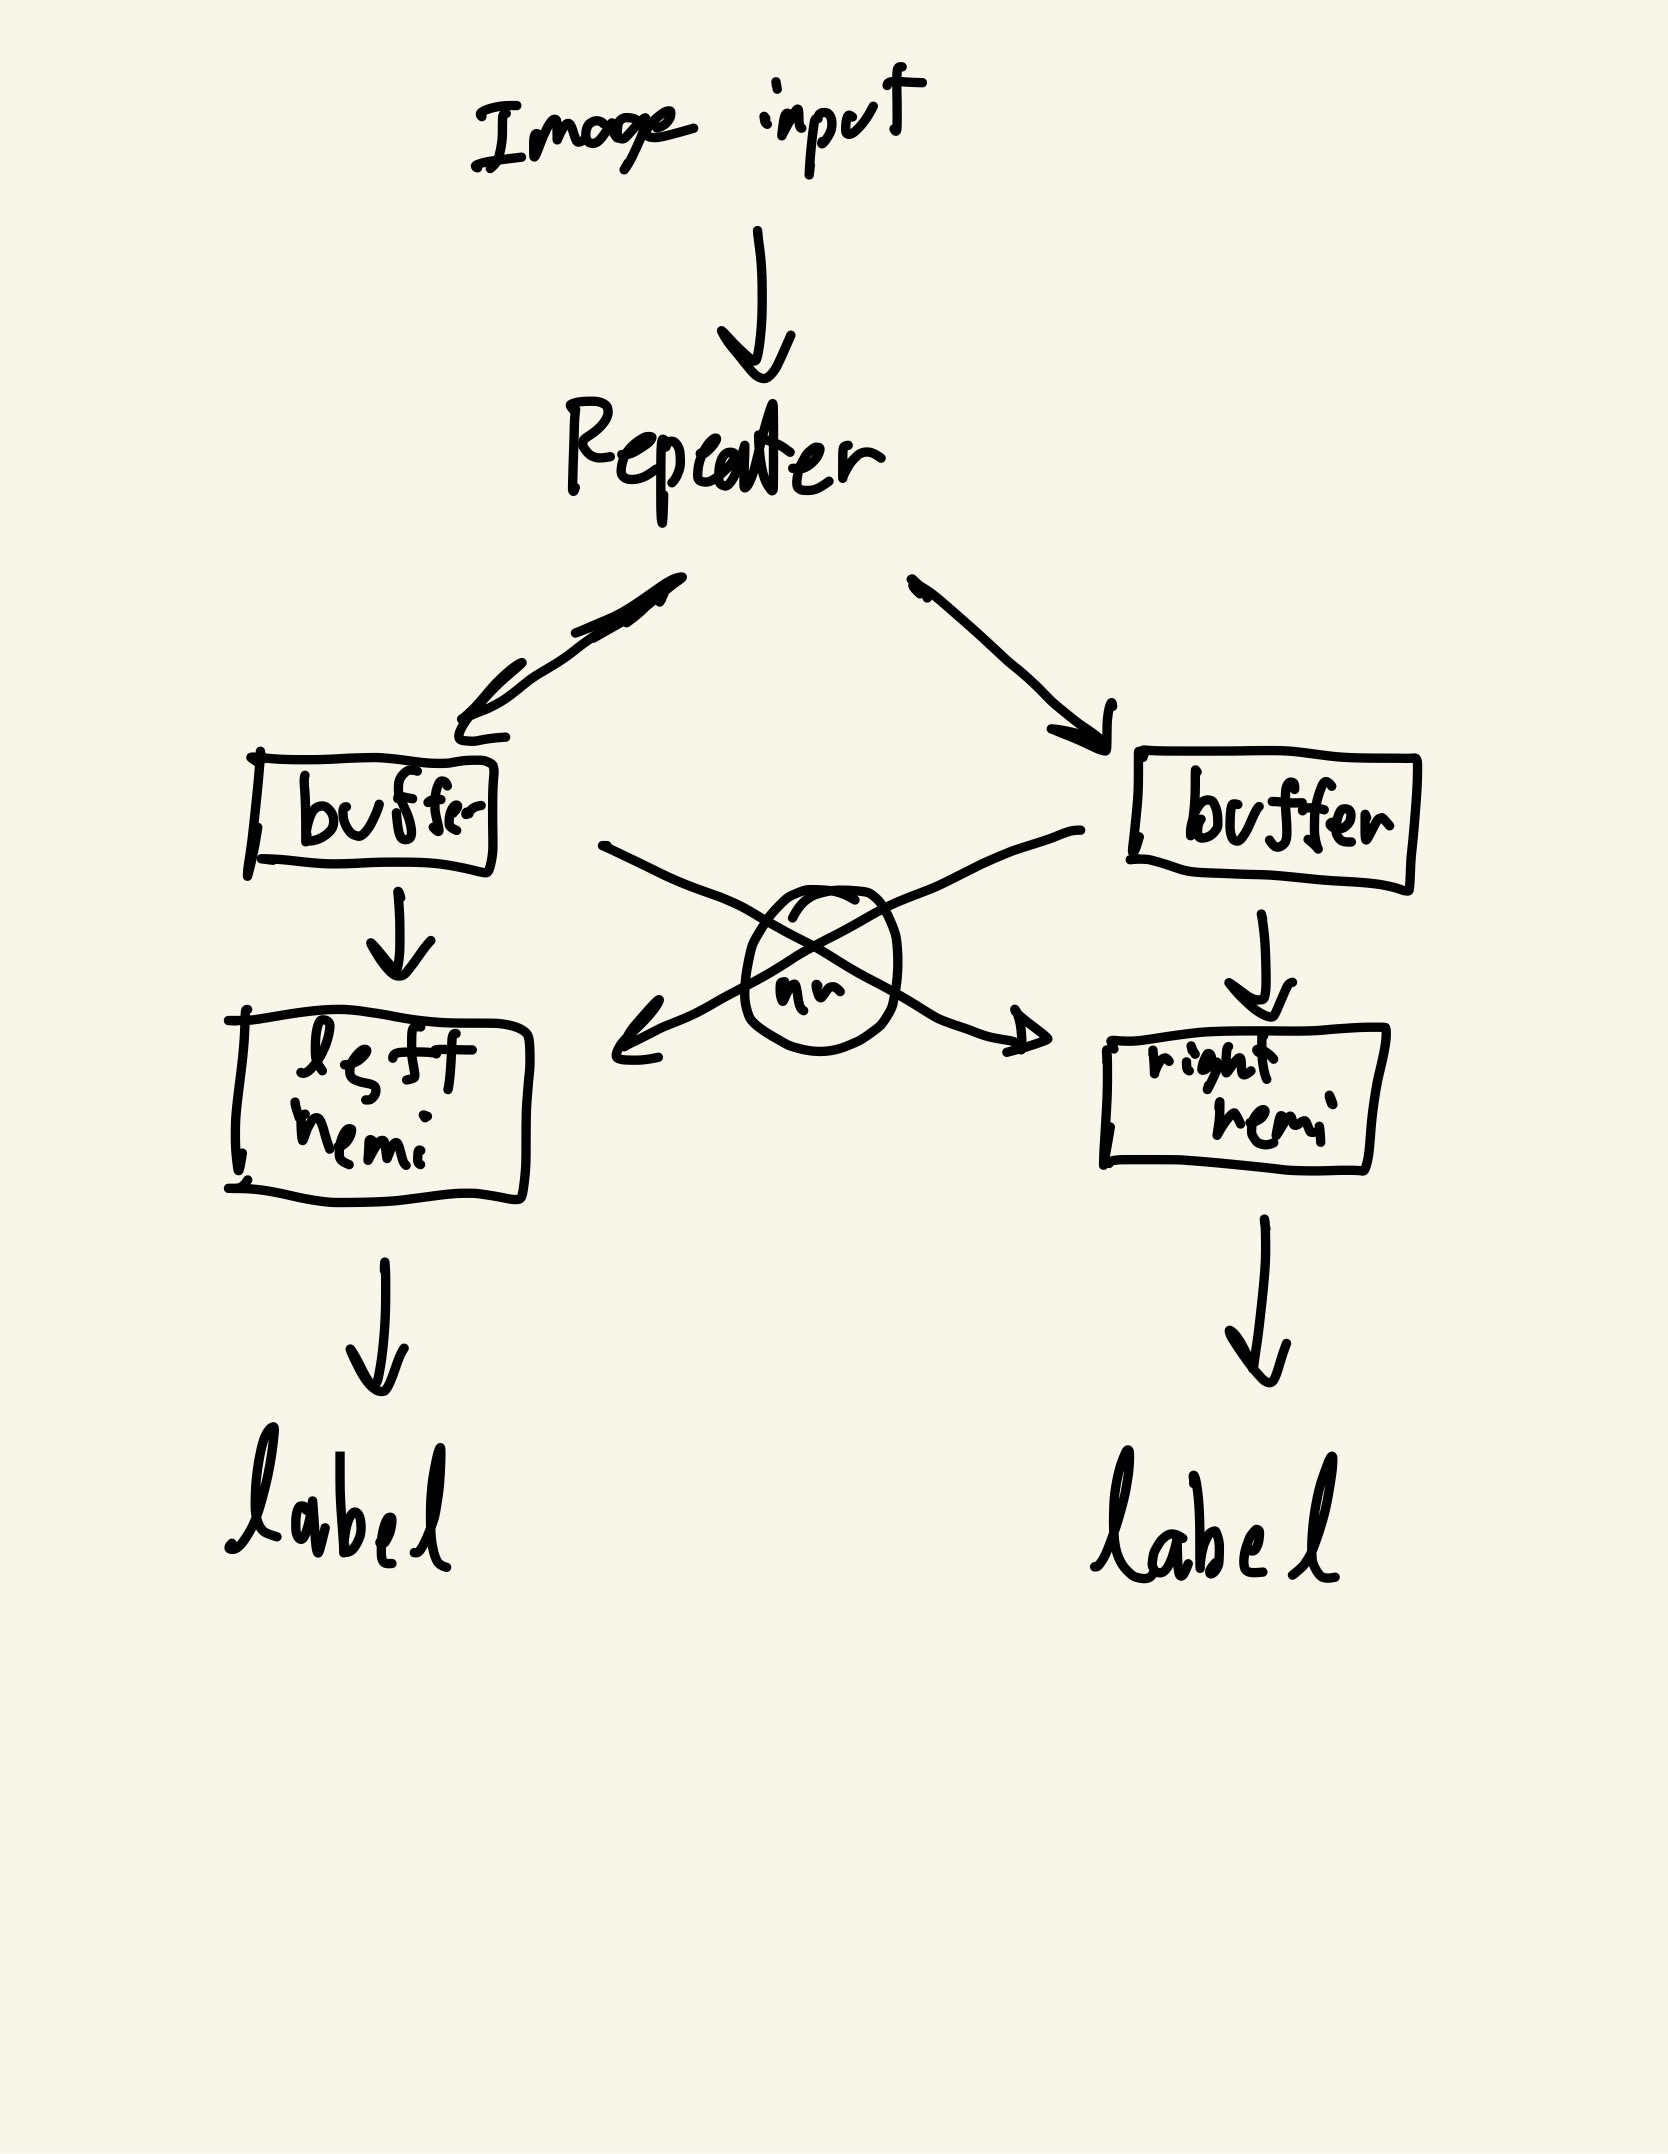

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

(train_set, test_set), dataset_info = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:]'], as_supervised=True, with_info=True)

In [2]:
def preprocess(img, label):
    img = tf.image.resize(img, (150, 150))
    img = img / 255.0
    return img, label

train_set = train_set.map(preprocess).batch(33).shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_set = test_set.map(preprocess).batch(32).shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [5]:
#Creating models

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout

input_layer = Input(shape=(150, 150, 3))
flatten_layer = Flatten()(input_layer)

# left_buffer
left_buffer_input = Dense(512, activation="relu")(flatten_layer)
left_buffer_mid = Dense(1024, activation="relu")(left_buffer_input)
left_buffer_mid = Dropout(0.3)(left_buffer_mid)
left_buffer_out = Dense(512, activation="relu")(left_buffer_mid)
left_buffer_out = Dropout(0.3)(left_buffer_out)

# right_buffer
right_buffer_input = Dense(512, activation="relu")(flatten_layer)
right_buffer_mid = Dense(1024, activation="relu")(right_buffer_input)
right_buffer_mid = Dropout(0.3)(right_buffer_mid)
right_buffer_out = Dense(512, activation="relu")(right_buffer_mid)
right_buffer_out = Dropout(0.3)(right_buffer_out)

# Corpus Callosum equivalence
right_left_nn = Dense(512, activation="relu")(right_buffer_out)
right_left_nn = Dropout(0.3)(right_left_nn)
right_left_nn = Dense(512, activation="relu")(right_left_nn)
right_left_nn = Dropout(0.3)(right_left_nn)
left_right_nn = Dense(512, activation="relu")(left_buffer_out)
left_right_nn = Dropout(0.3)(left_right_nn)
left_right_nn = Dense(512, activation="relu")(left_right_nn)
left_right_nn = Dropout(0.3)(left_right_nn)

# right_hemi

right_hemi_input = Concatenate()([left_right_nn, right_buffer_out])
right_hemi_mid = Dense(1024, activation="relu")(right_hemi_input)
right_hemi_mid = Dropout(0.3)(right_hemi_mid)
right_hemi_mid = Dense(512, activation="relu")(right_hemi_mid)
right_hemi_mid = Dropout(0.3)(right_hemi_mid)
right_hemi_mid = Dense(256, activation="relu")(right_hemi_mid)
right_hemi_mid = Dropout(0.3)(right_hemi_mid)
right_hemi_mid = Dense(64, activation="relu")(right_hemi_mid)
right_hemi_out = Dense(2, activation="sigmoid", name='right_out')(right_hemi_mid)

# left_hemi
left_hemi_input = Concatenate()([right_left_nn, left_buffer_out])
left_hemi_mid = Dense(1024, activation="relu")(left_hemi_input)
left_hemi_mid = Dropout(0.3)(left_hemi_mid)
left_hemi_mid = Dense(512, activation="relu")(left_hemi_mid)
left_hemi_mid = Dropout(0.3)(left_hemi_mid)
left_hemi_mid = Dense(256, activation="relu")(left_hemi_mid)
left_hemi_mid = Dropout(0.3)(left_hemi_mid)
left_hemi_mid = Dense(64, activation="relu")(left_hemi_mid)
left_hemi_out = Dense(2, activation="sigmoid", name='left_out')(left_hemi_mid)

model = Model(inputs=input_layer, outputs=[left_hemi_out, right_hemi_out])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 flatten_1 (Flatten)            (None, 67500)        0           ['input_2[0][0]']                
                                                                                                  
 dense_21 (Dense)               (None, 512)          34560512    ['flatten_1[0][0]']              
                                                                                                  
 dense_18 (Dense)               (None, 512)          34560512    ['flatten_1[0][0]']        

Total params: 75,716,484
Trainable params: 75,716,484
Non-trainable params: 0
__________________________________________________________________________________________________


In [6]:
model.fit(train_set, epochs=3, verbose=1, validation_data=test_set)

Epoch 1/3
564/564 [==============================] - 48s 30ms/step - loss: 1.6743 - left_out_loss: 0.8446 - right_out_loss: 0.8297 - left_out_accuracy: 0.5046 - right_out_accuracy: 0.5025 - val_loss: 1.3883 - val_left_out_loss: 0.6941 - val_right_out_loss: 0.6942 - val_left_out_accuracy: 0.4901 - val_right_out_accuracy: 0.4901
Epoch 2/3
564/564 [==============================] - 18s 27ms/step - loss: 1.3882 - left_out_loss: 0.6941 - right_out_loss: 0.6941 - left_out_accuracy: 0.4995 - right_out_accuracy: 0.5055 - val_loss: 1.3863 - val_left_out_loss: 0.6932 - val_right_out_loss: 0.6931 - val_left_out_accuracy: 0.4901 - val_right_out_accuracy: 0.5101
Epoch 3/3
564/564 [==============================] - 18s 26ms/step - loss: 1.3867 - left_out_loss: 0.6933 - right_out_loss: 0.6933 - left_out_accuracy: 0.4963 - right_out_accuracy: 0.5019 - val_loss: 1.3868 - val_left_out_loss: 0.6936 - val_right_out_loss: 0.6932 - val_left_out_accuracy: 0.4901 - val_right_out_accuracy: 0.4901


The architecture is not good as classifier